In [1]:
#Fill these file paths with the locations on your machine. 
PATH_TO_CODE = '' # path to the code folder of the repo
PATH_TO_PASTIS = ''


import sys
sys.path.append(PATH_TO_CODE)


import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib

cm = matplotlib.colormaps.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,20)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=21)

def get_rgb(x, batch_index=0, t_show=1):
    """Utility function to get a displayable rgb image 
    from a Sentinel-2 time series.
    """
    im = x['S2'][batch_index, t_show, [2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

def get_radar(x, batch_index=0, t_show=6, orbit='D'):
    """Utility function to get a displayable image 
    from a Sentinel-1 time series.
    """
    im = x['S1{}'.format(orbit)][batch_index, t_show].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

In [2]:
from dataloader import PASTIS_Dataset
from collate import pad_collate

dt = PASTIS_Dataset(PATH_TO_PASTIS, norm=True, target='semantic')
# If you only need to evaluate semantic segmentation use target='semantic'

dl = torch.utils.data.DataLoader(dt, batch_size=300, collate_fn=pad_collate, shuffle=True)

Reading patch metadata . . .
Done.
Dataset ready.


In [3]:
# Loading a batch from the dataloader
(x, dates), y = dl.__iter__().__next__()

# x is a dictionary thay contains the Sentinel-2 time series
# in the 'S2' key, shape: B x T x C x H x W
print(x.keys())
print(x['S2'].shape)
# dates contains the observation dates of each image, shape: B x T
print(dates['S2'].shape)
# y is the target label, shape: B x H x W
print(y.shape)

dict_keys(['S2'])
torch.Size([300, 61, 10, 128, 128])
torch.Size([300, 61])
torch.Size([300, 128, 128])


In [4]:
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score

In [5]:
dl_ex = torch.utils.data.DataLoader(dt, batch_size=100, collate_fn=pad_collate, shuffle=True)
(x_ex, dates), y_ex = dl_ex.__iter__().__next__()
# Flatten the time series
x_ex_flat = x_ex['S2'].numpy()
x_ex_flat = x_ex_flat[:, 0, :, :, :]
x_ex_flat = x_ex_flat.reshape([x_ex_flat.shape[0], -1])

# Flatten the labels
y_ex_flat = y_ex.view(y_ex.shape[0], -1)

Text(0.5, 1.0, 'Semantic labels.')

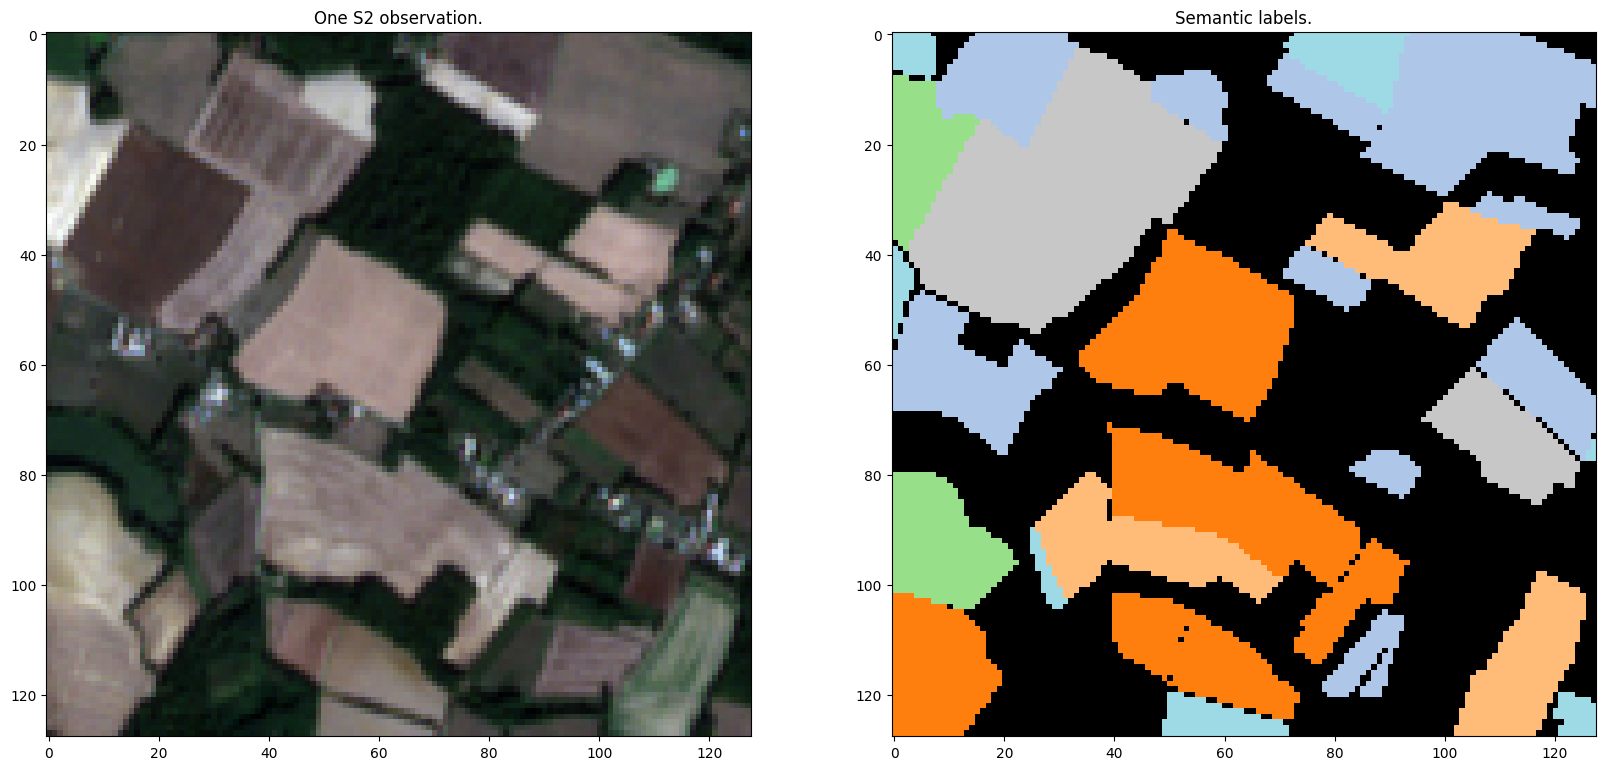

In [6]:
bid = 0 # Which element of the batch to plot

fix, axes = plt.subplots(1,2, figsize=(20,20))

axes[0].imshow(get_rgb(x_ex, batch_index=bid))
axes[1].imshow(y_ex[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('One S2 observation.')
axes[1].set_title('Semantic labels.')


In [7]:
img = get_rgb(x_ex, batch_index=bid) # np array
original_shape = img.shape

X = img.reshape(-1, 3)

In [8]:
bandwidth = estimate_bandwidth(X, quantile=0.1)
print(bandwidth)

0.08072984034108908


In [9]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

MeanShift(bandwidth=0.08072984034108908, bin_seeding=True)

In [10]:
labels = ms.labels_
print(labels.shape)
cluster_centers = ms.cluster_centers_
print(cluster_centers.shape)

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

(16384,)
(11, 3)
number of estimated clusters : 11


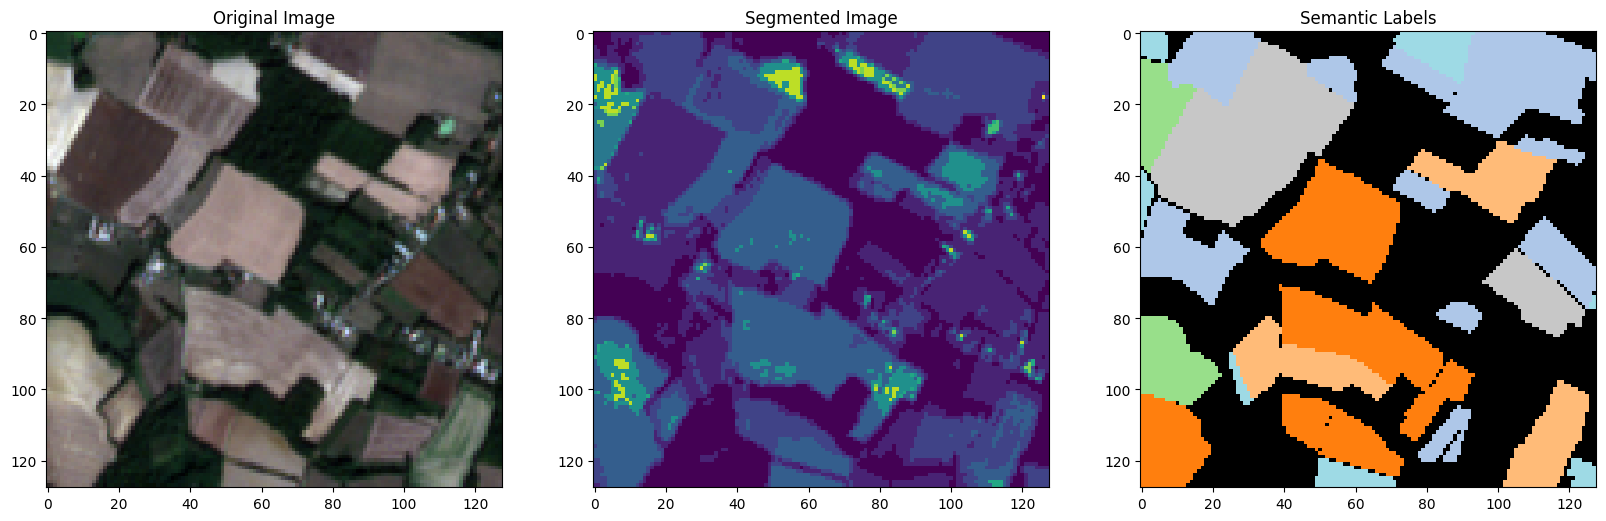

In [11]:
segmented_image = np.reshape(labels, original_shape[:2])

fix, axes = plt.subplots(1,3, figsize=(20,20))

axes[0].imshow(img)
axes[1].imshow(segmented_image)
axes[2].imshow(y_ex[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('Original Image')
axes[1].set_title('Segmented Image')
axes[2].set_title('Semantic Labels')

plt.show()

In [37]:
# image = get_rgb(x_ex, batch_index=bid)
# print(image.shape)

# image_float = image.astype(np.float32)
# rows, cols, _ = image_float.shape
# image_2d = image_float.reshape(rows*cols, 3)
# print(image_2d.shape)

# bandwidth = estimate_bandwidth(image_2d, quantile=0.5, n_jobs=1)
# ms_labels = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=1).fit_predict(image_2d)
# print(ms_labels.shape)

# print(min(ms_labels))
# print(max(ms_labels))

# ms_labels = ms_labels.reshape(rows, cols)

# plt.figure(figsize=(20,20))
# plt.imshow(ms_labels)
# plt.show()



In [40]:
ious = []
#calculate iou for each img in the batch
for i in range(100):
    img = get_rgb(x_ex, batch_index=i)
    X = img.reshape(-1, 3)
    bandwidth = estimate_bandwidth(X, quantile=0.1)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    
    y_pred = ms.labels_
    y_true = y_ex[i].flatten()
    
    iou = jaccard_score(y_true, y_pred, average='weighted')
    ious.append(iou)

mean_iou = np.mean(ious)
print(mean_iou)


0.28338275296301774
